Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [108]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
from pathlib import Path

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

# Downloading Data from Drive.
import gdown
import zipfile
import os

# Google Drive file URL
file_url = 'https://drive.google.com/uc?id=1Tj9gSWWuqqBQxJaLmOERKewSPmDvzUrx'

# Output file path
output_file = './downloaded_file.zip'

# Download the file
gdown.download(file_url, output_file, quiet=False)

# Extract the contents of the zip file
with zipfile.ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall('./extracted_content')

# Remove the downloaded zip file
os.remove(output_file)

print("Zip file downloaded and extracted successfully!")



Downloading...
From (original): https://drive.google.com/uc?id=1Tj9gSWWuqqBQxJaLmOERKewSPmDvzUrx
From (redirected): https://drive.google.com/uc?id=1Tj9gSWWuqqBQxJaLmOERKewSPmDvzUrx&confirm=t&uuid=85f8eca4-c984-4c98-9add-9217ccf01e18
To: /content/downloaded_file.zip
100%|██████████| 824M/824M [00:32<00:00, 25.2MB/s]


Zip file downloaded and extracted successfully!


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# checking for downloaded data.
!ls -l "extracted_content/Skin cancer ISIC The International Skin Imaging Collaboration"

total 8
drwxr-xr-x 11 root root 4096 May  4 16:56 Test
drwxr-xr-x 11 root root 4096 May  4 16:56 Train


In [56]:
!ls -l extracted_content

total 4
drwxr-xr-x 4 root root 4096 May  4 16:56 'Skin cancer ISIC The International Skin Imaging Collaboration'


In [57]:
!mv "extracted_content/Skin cancer ISIC The International Skin Imaging Collaboration" "extracted_content/images"

In [58]:
!ls -l extracted_content

total 4
drwxr-xr-x 4 root root 4096 May  4 16:56 images


In [59]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("extracted_content/images/Train")
data_dir_test = pathlib.Path('extracted_content/images/Test')

In [60]:
# Display the Count of Images in Each Folder, and SubFolder.

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("image_count_train : ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("image_count_test : ", image_count_test)

image_count_train :  2239
image_count_test :  118


In [61]:
import pandas as pd
import pathlib

# Paths to training and testing datasets
data_dir_train = pathlib.Path("extracted_content/images/Train")
data_dir_test = pathlib.Path("extracted_content/images/Test")

# Function to count files in each sub-folder
def count_files_in_subfolders(directory):
    folder_counts = {}
    for folder_path in directory.glob('*'):
        if folder_path.is_dir():
            folder_counts[folder_path.name] = len(list(folder_path.glob('*.jpg')))
    return folder_counts

# Count files in each sub-folder within Train and Test directories
train_counts = count_files_in_subfolders(data_dir_train)
test_counts = count_files_in_subfolders(data_dir_test)

# Convert counts to DataFrame
df_counts = pd.DataFrame({
    'Train Images': pd.Series(train_counts),
    'Test Images': pd.Series(test_counts)
})

# Calculate total counts
total_train = df_counts['Train Images'].sum()
total_test = df_counts['Test Images'].sum()

# Calculate percentages
df_counts['Train %'] = (df_counts['Train Images'] / total_train * 100).round(2)
df_counts['Test %'] = (df_counts['Test Images'] / total_test * 100).round(2)

# Display the DataFrame
print(df_counts)


                            Train Images  Test Images  Train %  Test %
squamous cell carcinoma              181           16     8.08   13.56
seborrheic keratosis                  77            3     3.44    2.54
actinic keratosis                    114           16     5.09   13.56
dermatofibroma                        95           16     4.24   13.56
melanoma                             438           16    19.56   13.56
basal cell carcinoma                 376           16    16.79   13.56
vascular lesion                      139            3     6.21    2.54
pigmented benign keratosis           462           16    20.63   13.56
nevus                                357           16    15.94   13.56


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [78]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset


# Creating the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,               # The directory of training images
  validation_split=0.2,         # Specifies the fraction of data to reserve for validation
  subset="training",            # Indicates that this dataset is for training
  seed=123,                     # Seed used for shuffling and transformations
  image_size=(img_height, img_width), # The target size of the images
  batch_size=batch_size)        # The size of the batches of data


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [79]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset


# Creating the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,               # The directory of training images, also used for validation due to the split
  validation_split=0.2,         # Specifies the fraction of data to reserve for validation
  subset="validation",          # Indicates that this dataset is for validation
  seed=123,                     # Seed used for shuffling and transformations, consistent with training dataset
  image_size=(img_height, img_width), # The target size of the images, must match training dataset
  batch_size=batch_size)        # The size of the batches of data


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [80]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

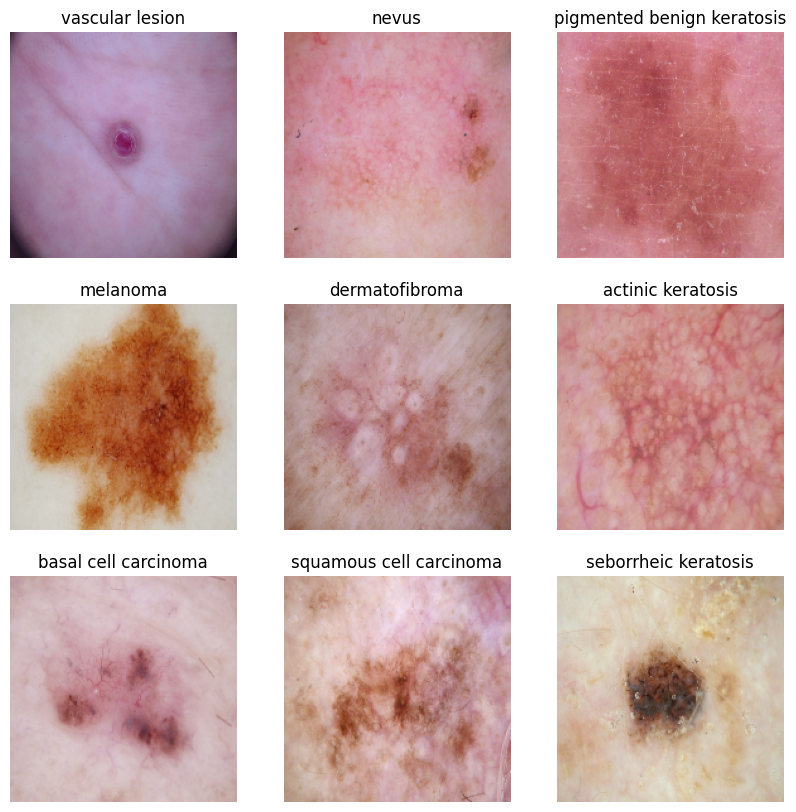

In [11]:
import matplotlib.pyplot as plt

# Initialize a set to track which classes have been displayed
displayed_classes = set()

# Initialize the figure for displaying images
plt.figure(figsize=(10, 10))
found = 0  # Counter for number of unique classes found

# Loop through batches of images from the training dataset
for images, labels in train_ds:
    for i in range(len(labels)):
        # Check if the class of the current image has been displayed already
        if class_names[labels[i]] not in displayed_classes:
            # If not, set up the subplot and show the image
            ax = plt.subplot(3, 3, found + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

            # Add the class to the set of displayed classes
            displayed_classes.add(class_names[labels[i]])
            found += 1  # Increment the counter

            # Break the loop once all classes have been displayed
            if found == len(class_names):
                break
    if found == len(class_names):
        break

# Display the plot
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
# We are dealing with limited Disk space and Memory.
# PreFetch will reduce model training time. Pre fetches remaining Batch Data.

# AUTOTUNE automatically adjusts the amount of computational resources allocated for preparing data,
# allowing the system to dynamically manage resource allocation to maximize throughput during training.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Here, the training dataset is cached, shuffled, and prefetched. Caching is particularly useful when the dataset
# can fit into memory. It keeps the images in memory after they're loaded off disk during the first epoch,
# which means the dataset does not have to be reloaded from disk in subsequent epochs. This can save a lot
# of I/O time.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# The validation dataset is also cached and prefetched. This setup helps reduce I/O time during validation
# as the data only needs to be loaded once and can be kept in memory. Prefetching helps in preparing data
# while the model is working on another batch of data, effectively overlapping data preprocessing and model
# execution, which can significantly speed up the training process.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here

# Do ReScaling to standardize. To get pixel values 0 to 1.
# Mention the Layers required here.

# the Last Softmax Classification layer should have 9 classes

## Try with 3 CNN Layers to start with.


In [14]:
# Create the Model.

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the input shape
input_shape = (180, 180, 3)  # As images are 180x180 with 3 channels (RGB)

# Create the model using the Sequential API
model = Sequential([
    # Rescaling layer to normalize the pixel values
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

    # First convolutional block
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    # Second convolutional block
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    # Third convolutional block
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    # Flatten the convolution output to feed into the dense layers
    Flatten(),

    # Dense layer with dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Output layer with 9 units (one for each class) with softmax activation for multi-class classification
    Dense(9, activation='softmax')
])




### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
# best optimizer could be Adam here.
# or Cross Entropy based one can be good.

# model.compile(optimizer='your_optimser',
#               loss=your_loss_function_goes_here,
#               metrics=['accuracy'])

# Compile the Model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

# compare Accuracy for different models.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 90, 90, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        1

### Train the model

In [21]:
# Train the Model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Train the Model
# epochs = 20
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs,
#   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
# )

Epoch 1/20
56/56 [==============================] - 5s 90ms/step - loss: 1.8249 - accuracy: 0.3041 - val_loss: 2.4038 - val_accuracy: 0.2438
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 1.8429 - accuracy: 0.3092 - val_loss: 1.7571 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 5s 96ms/step - loss: 1.8211 - accuracy: 0.3108 - val_loss: 1.9243 - val_accuracy: 0.3177
Epoch 4/20
56/56 [==============================] - 5s 92ms/step - loss: 1.8052 - accuracy: 0.3064 - val_loss: 3.6069 - val_accuracy: 0.2819
Epoch 5/20
56/56 [==============================] - 5s 91ms/step - loss: 1.8032 - accuracy: 0.3086 - val_loss: 4.1359 - val_accuracy: 0.1834
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 1.8162 - accuracy: 0.3080 - val_loss: 1.7324 - val_accuracy: 0.3378
Epoch 7/20
56/56 [==============================] - 5s 92ms/step - loss: 1.8007 - accuracy: 0.3064 - val_loss: 1.8293 - val_accuracy: 0.3043
Epoch 8/20
56

### Visualizing training results

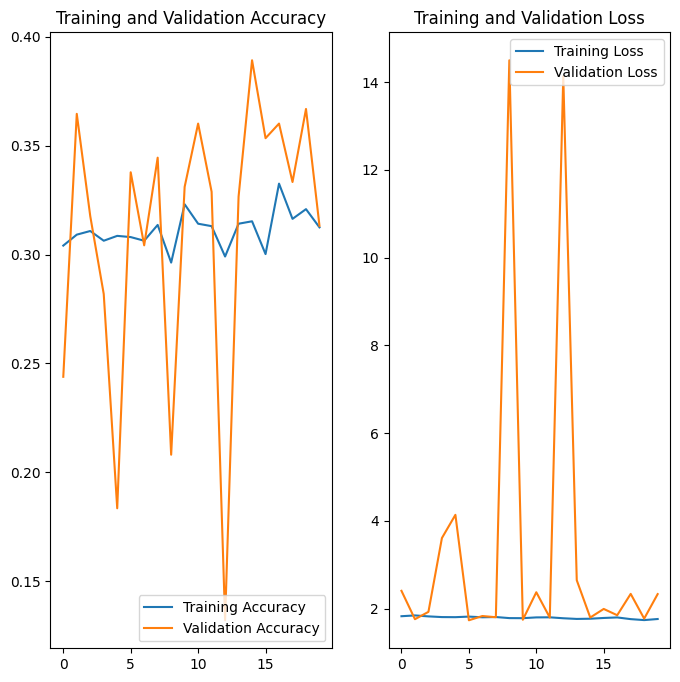

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [24]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print("Loss:", loss)
print("Accuracy:", accuracy)

14/14 [==============================] - 0s 32ms/step - loss: 2.3292 - accuracy: 0.3132
Loss: 2.329155921936035
Accuracy: 0.31319910287857056


In [ ]:
# Analysis of Results

# Test for Overfitting and Underfitting.
# Overfitting will happen when there is high accuracy in Training, but low in Testing.
# In that case use Regularization metods as Drop outs, or Batch Regularization
# can use Data Augmentation Strategies
# for Underfitting add more CNN Layers.




# Stable but Low Accuracy: Both training and validation accuracies are low, with training accuracy hovering around 30% and validation accuracy varying more widely but remaining generally low.
# This suggests that the model is not learning effectively from the training data.

# High and Fluctuating Validation Loss: The validation loss shows significant fluctuations and spikes (e.g., epochs 9 and 13 show extremely high validation losses).
# Such behavior often indicates that the model is not generalizing well to new, unseen data, suggesting potential issues with model architecture or the representativeness of the training data.

# Lack of Improvement Over Time: Generally, you would expect some trend of improvement in both loss and accuracy as training progresses if the model is learning effectively.
# However, results show minimal improvement in these metrics, suggesting the model could be underfitting.


####################################################################
## Indications

# Underfitting: The model’s consistent low accuracy and failure to improve significantly over time indicate underfitting.
# Underfitting occurs when the model is too simple to learn the underlying pattern of the data. It can be due to inadequate model complexity, insufficient training, or poor feature extraction capabilities in the model.

# Poor Generalization: The fluctuations and high peaks in validation loss suggest that the model's ability to generalize from training data to validation data is poor.
# This might be improved by better training strategies or revising the model structure.


####################################################################
## Recommendations to Improve the Model


# Increase Model Complexity: Consider adding more convolutional layers or increasing the number of neurons in the dense layers.
# This can help in capturing more complex patterns in the data.

# Revise the Model Architecture: Experiment with different architectures. Adding or adjusting layers such as Dropout or BatchNormalization might help in managing overfitting and improving generalization.

# Data Augmentation: Implementing data augmentation can artificially expand the diversity of your training dataset by applying random, yet realistic, transformations to the training images (e.g., rotations, scaling, flips).
# This can help improve model robustness and generalization.

# Hyperparameter Tuning: Experiment with different learning rates, batch sizes, or other optimizer settings. Sometimes, small adjustments in these parameters can lead to significant improvements in model performance.

# Advanced Regularization Techniques: Utilize regularization techniques such as L1/L2 regularization in the convolutional and dense layers, or experiment with different dropout rates.

# Increase Training Data: If possible, increasing the number of training examples can help improve model accuracy and robustness by providing a more comprehensive representation of the problem space.

# Longer Training: More epochs might be necessary, but this should be approached cautiously and in combination with strategies to prevent overfitting, such as early stopping or using a dynamic learning rate.

# Evaluate Learning Curves: Detailed analysis of the learning curves for accuracy and loss might provide deeper insights into whether the model is learning more effectively at certain stages of training or if adjustments need to be made in the learning process.



In [27]:

# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

# Define the input shape
input_shape = (180, 180, 3)  # As images are 180x180 with 3 channels (RGB)

# Data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Create the model using the Sequential API
model = Sequential([
    # Data augmentation layer
    data_augmentation,

    # Rescaling layer to normalize the pixel values
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    # First convolutional block
    Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    BatchNormalization(),

    # Second convolutional block
    Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    BatchNormalization(),

    # Third convolutional block
    Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    BatchNormalization(),

    # Additional convolutional block to increase complexity
    Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(),
    BatchNormalization(),

    # Flatten the convolution output to feed into the dense layers
    Flatten(),

    # Dense layer with dropout for regularization
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output layer with 9 units (one for each class) with softmax activation for multi-class classification
    Dense(9, activation='softmax')
])




In [29]:
# Compile the model with an appropriate optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [31]:
# Model summary to inspect architecture
model.build(input_shape=(None, 180, 180, 3))  # None for batch size, which can vary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 90, 90, 64)        256       
 chNormalization)                                     

In [32]:
# Train the Model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 33s 290ms/step - loss: 3.7559 - accuracy: 0.3521 - val_loss: 4.4384 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 12s 218ms/step - loss: 2.7482 - accuracy: 0.4118 - val_loss: 5.2714 - val_accuracy: 0.0537
Epoch 3/20
56/56 [==============================] - 12s 219ms/step - loss: 2.6239 - accuracy: 0.4581 - val_loss: 6.9882 - val_accuracy: 0.0537
Epoch 4/20
56/56 [==============================] - 12s 219ms/step - loss: 2.5921 - accuracy: 0.4537 - val_loss: 8.7770 - val_accuracy: 0.0537
Epoch 5/20
56/56 [==============================] - 12s 218ms/step - loss: 2.5585 - accuracy: 0.4671 - val_loss: 9.8418 - val_accuracy: 0.0537
Epoch 6/20
56/56 [==============================] - 13s 228ms/step - loss: 2.4942 - accuracy: 0.4989 - val_loss: 9.4166 - val_accuracy: 0.0559
Epoch 7/20
56/56 [==============================] - 12s 218ms/step - loss: 2.4719 - accuracy: 0.4983 - val_loss: 7.2347 - val_accuracy: 0.0940

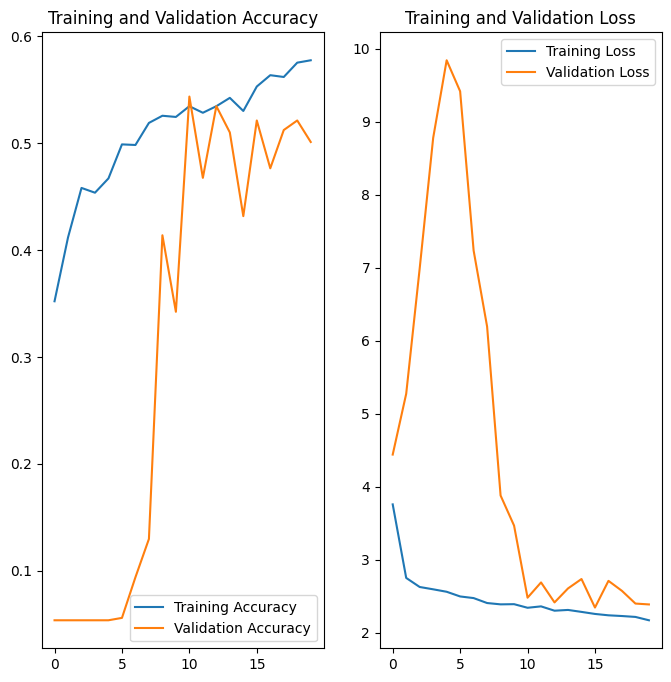

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

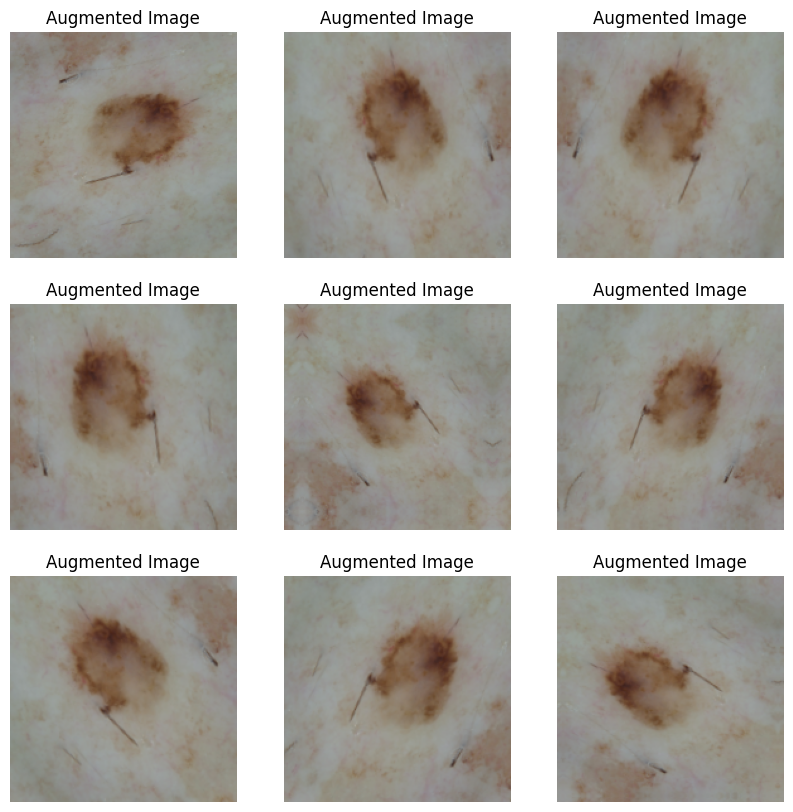

In [34]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with various augmentations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Display a function to visualize the augmented images
def plot_example_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.title("Augmented Image")
            plt.axis("off")
    plt.show()

# Assuming train_ds is your dataset
plot_example_images(train_ds)


### Todo:
### Create the model, compile and train the model


In [ ]:
### Possible Causes for Initial Poor Performance in Second Run
# High Initial Loss: This might be due to an overly aggressive learning rate or poor initial weights that initially drove the predictions to be very wrong.
# Gradual Improvement: The model seems to "recover" as training progresses, likely adjusting weights significantly from the initially poor starting point.


### Recommendations for Optimization
# 1. Adjust Learning Rate: An initially high learning rate might cause the model to converge too quickly to a poor local minimum, which might explain the initial high loss values.

# 2. Implement a Learning Rate Scheduler: This will adjust the learning rate dynamically based on the training epoch, allowing for larger updates initially and finer, smaller updates as training progresses.

# 3. More Advanced Data Augmentation: Increasing the variety of training data seen by the model can help improve generalization, particularly to prevent overfitting and help the model learn more robust features.

# 4. Use Early Stopping: To prevent overfitting and to stop training when the validation scores do not improve.

# 5. Revisit Model Complexity: If the model continues to underperform, consider increasing its complexity slightly more or revisiting the dropout rates to balance between learning capacity and overfitting.

In [35]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the input shape and initialize the data augmentation configuration
input_shape = (180, 180, 3)  # As images are 180x180 with 3 channels (RGB)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Build the model
model = Sequential([
    # Data augmentation layer
    data_augmentation,

    # Rescaling layer to normalize the pixel values
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

    # First convolutional block
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    # Second convolutional block
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    # Optional dropout for regularization
    Dropout(0.3),  # Adjust dropout rate based on the level of overfitting observed

    # Third convolutional block
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    # Flatten the convolution output to feed into the dense layers
    Flatten(),

    # Dense layer with dropout for additional regularization
    Dense(512, activation='relu'),
    Dropout(0.5),  # Increase or decrease based on validation performance

    # Output layer with 9 units (one for each class) with softmax activation for multi-class classification
    Dense(9, activation='softmax')
])

# Learning rate scheduler definition
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callbacks for learning rate adjustment and early stopping
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)







Epoch 1/20
56/56 [==============================] - 22s 300ms/step - loss: 26.0096 - accuracy: 0.2427 - val_loss: 30.9202 - val_accuracy: 0.0492 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 17s 303ms/step - loss: 4.3280 - accuracy: 0.2589 - val_loss: 7.9241 - val_accuracy: 0.1611 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 17s 301ms/step - loss: 2.1361 - accuracy: 0.3036 - val_loss: 5.5276 - val_accuracy: 0.1588 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 16s 285ms/step - loss: 1.9540 - accuracy: 0.3387 - val_loss: 5.8812 - val_accuracy: 0.1611 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 16s 290ms/step - loss: 1.8501 - accuracy: 0.3638 - val_loss: 4.0105 - val_accuracy: 0.2327 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 16s 282ms/step - loss: 1.8227 - accuracy: 0.3488 - val_loss: 5.3116 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 16s 289ms/

### Compiling the model

In [36]:
## Your code goes here

# Compile the model with an initial learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [41]:
## Your code goes here, note: train your model for 20 epochs

#history = ## your training code

# Model training with callbacks for learning rate scheduling and early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[callback_lr, callback_es]
)



Epoch 1/20
56/56 [==============================] - 17s 294ms/step - loss: 1.8359 - accuracy: 0.2997 - val_loss: 2.0853 - val_accuracy: 0.1633 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 16s 283ms/step - loss: 1.8963 - accuracy: 0.3125 - val_loss: 3.9541 - val_accuracy: 0.1432 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 16s 291ms/step - loss: 1.8619 - accuracy: 0.3248 - val_loss: 1.7943 - val_accuracy: 0.3311 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 16s 286ms/step - loss: 1.7832 - accuracy: 0.3214 - val_loss: 2.1272 - val_accuracy: 0.3714 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 16s 291ms/step - loss: 1.8073 - accuracy: 0.3119 - val_loss: 1.7491 - val_accuracy: 0.3803 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 16s 284ms/step - loss: 1.7677 - accuracy: 0.3376 - val_loss: 6.4167 - val_accuracy: 0.2215 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 16s 285ms/st

In [42]:
# Print model summary to verify architecture
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 90, 90, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_11 (Ba  (None, 90, 90, 64)        256       
 tchNormalization)                                    

### Visualizing the results

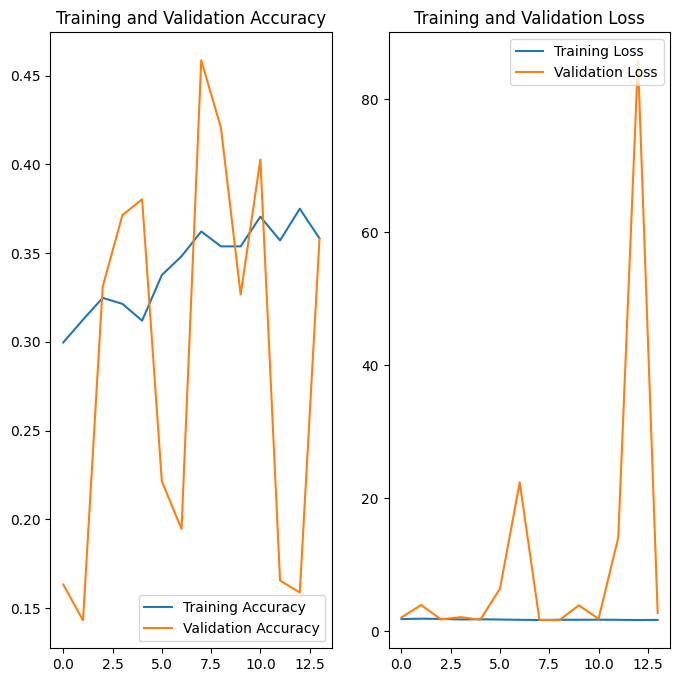

In [43]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable holding the training history returned by model.fit()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Correcting the range to match the length of the history data
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#### Observations and Potential Issues:

# Overfitting: Despite some episodes where validation accuracy is reasonable, the extreme spikes in validation loss in later epochs (e.g., 22.3966 in epoch 7 and 85.8553 in epoch 13) are typical signs of overfitting. The model may be learning to memorize the training data rather than generalizing from it.

# Inconsistency: The sharp inconsistencies between training and validation metrics suggest that the model's learning is not stable.
# This might be due to inadequate or improper regularization, extreme learning rates, or issues with the data itself (e.g., not enough data, poorly distributed classes, etc.).

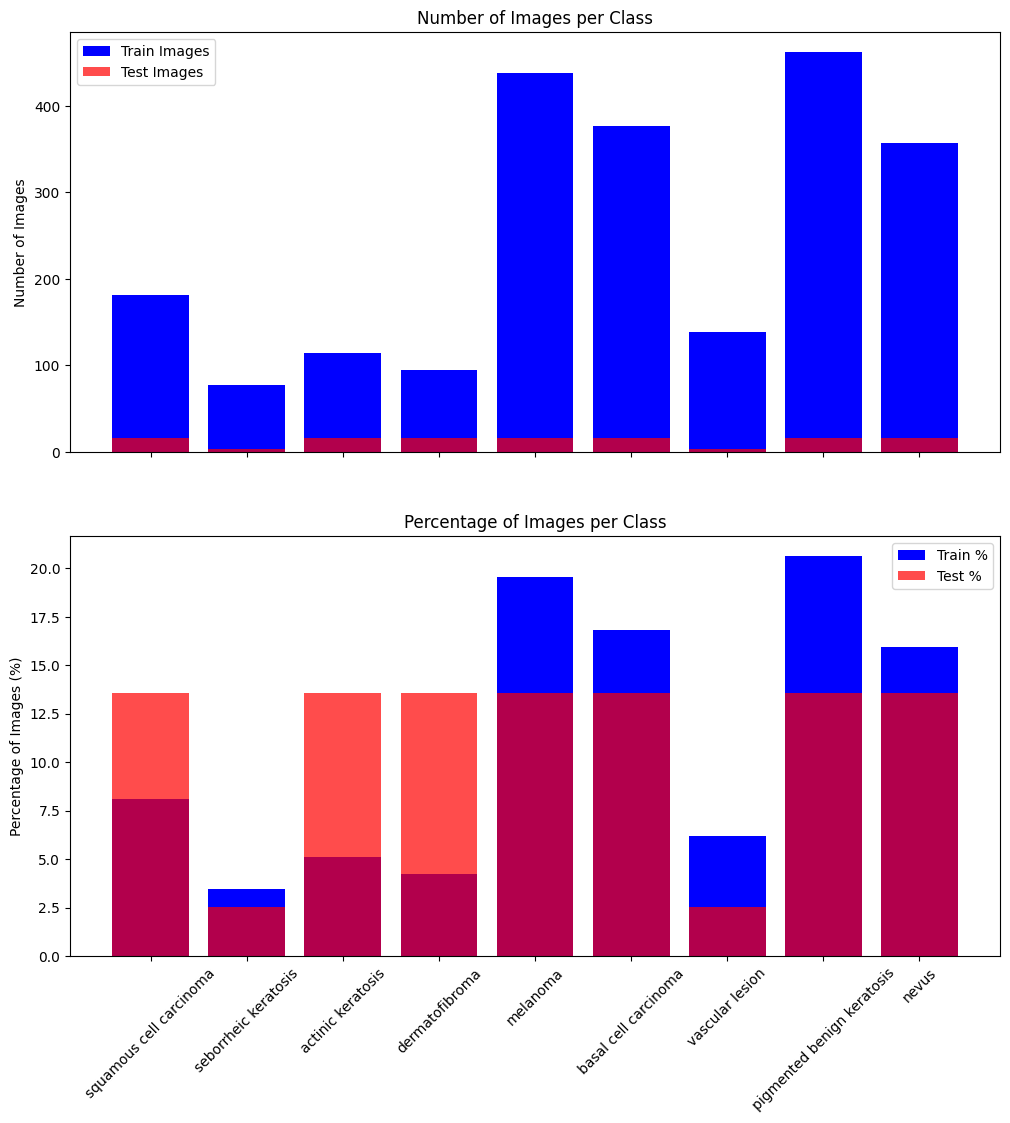

In [45]:
# Check for Class Imbalance. Few groups should not have more Samples.
# Show the Number of Labels per Class.


# Visualizing the data
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Bar chart for absolute counts
ax[0].bar(df_counts.index, df_counts['Train Images'], color='b', label='Train Images')
ax[0].bar(df_counts.index, df_counts['Test Images'], color='r', alpha=0.7, label='Test Images')
ax[0].set_ylabel('Number of Images')
ax[0].set_title('Number of Images per Class')
ax[0].legend()

# Bar chart for percentages
ax[1].bar(df_counts.index, df_counts['Train %'], color='blue', label='Train %')
ax[1].bar(df_counts.index, df_counts['Test %'], color='red', alpha=0.7, label='Test %')
ax[1].set_ylabel('Percentage of Images (%)')
ax[1].set_title('Percentage of Images per Class')
ax[1].legend()

# Show the plots
plt.xticks(rotation=45)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [46]:
# To Handle Classes which imbalance the Dataset.
## Augmentor will help create sample images with slight distortions. Tilt/Stretch of original image.
# Will help to create same weightage for images, based on count per class.

## Need to convert Tensor into Numpy array to extract information. to convert y_train into Categorical



!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [75]:
path_to_training_dataset='./extracted_content/images/Train'
!ls -l $path_to_training_dataset

total 108
drwxr-xr-x 2 root root  4096 May  4 16:56 'actinic keratosis'
drwxr-xr-x 2 root root 20480 May  4 16:56 'basal cell carcinoma'
drwxr-xr-x 2 root root  4096 May  4 16:56  dermatofibroma
drwxr-xr-x 2 root root 20480 May  4 16:56  melanoma
drwxr-xr-x 2 root root 20480 May  4 16:56  nevus
drwxr-xr-x 2 root root 20480 May  4 16:56 'pigmented benign keratosis'
drwxr-xr-x 2 root root  4096 May  4 16:56 'seborrheic keratosis'
drwxr-xr-x 2 root root 12288 May  4 16:56 'squamous cell carcinoma'
drwxr-xr-x 2 root root  4096 May  4 16:57 'vascular lesion'


In [81]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [86]:
#!ls -l './extracted_content/images/Train/actinic keratosis'

In [88]:
import pandas as pd
import pathlib

# Paths to training and testing datasets
# data_dir_train = pathlib.Path("extracted_content/images/Train")
# data_dir_test = pathlib.Path("extracted_content/images/Test")

# Function to count files in each sub-folder
# def count_files_in_subfolders(directory):
#     folder_counts = {}
#     for folder_path in directory.glob('*'):
#         if folder_path.is_dir():
#             folder_counts[folder_path.name] = len(list(folder_path.glob('*.jpg')))
#     return folder_counts

# # Count files in each sub-folder within Train and Test directories
# train_counts = count_files_in_subfolders(data_dir_train)
# test_counts = count_files_in_subfolders(data_dir_test)

# # Convert counts to DataFrame
# df_counts = pd.DataFrame({
#     'Train Images': pd.Series(train_counts),
#     'Test Images': pd.Series(test_counts)
# })

# # Calculate total counts
# total_train = df_counts['Train Images'].sum()
# total_test = df_counts['Test Images'].sum()

# # Calculate percentages
# df_counts['Train %'] = (df_counts['Train Images'] / total_train * 100).round(2)
# df_counts['Test %'] = (df_counts['Test Images'] / total_test * 100).round(2)

# Display the DataFrame to List Current Count and Distribution of Images in Each Class/Folder
print(df_counts)


                            Train Images  Test Images  Train %  Test %
squamous cell carcinoma              181           16     8.08   13.56
seborrheic keratosis                  77            3     3.44    2.54
actinic keratosis                    114           16     5.09   13.56
dermatofibroma                        95           16     4.24   13.56
melanoma                             438           16    19.56   13.56
basal cell carcinoma                 376           16    16.79   13.56
vascular lesion                      139            3     6.21    2.54
pigmented benign keratosis           462           16    20.63   13.56
nevus                                357           16    15.94   13.56


In [87]:
import Augmentor
for i in class_names:
    print("\n * * * Now Processing : " + path_to_training_dataset+"/"+i + "* * * ")
    p = Augmentor.Pipeline(path_to_training_dataset +"/"+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    print("\n * * * * * * * * * * * * * * * * * ")

./extracted_content/images/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to ./extracted_content/images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA212E2BCA0>: 100%|██████████| 500/500 [00:15<00:00, 32.23 Samples/s]


./extracted_content/images/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to ./extracted_content/images/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AA212E138B0>: 100%|██████████| 500/500 [00:16<00:00, 30.83 Samples/s]


./extracted_content/images/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to ./extracted_content/images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA2AF774BB0>: 100%|██████████| 500/500 [00:17<00:00, 27.92 Samples/s]


./extracted_content/images/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to ./extracted_content/images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AA22E0DDA20>: 100%|██████████| 500/500 [01:20<00:00,  6.24 Samples/s]


./extracted_content/images/Train/nevus
Initialised with 357 image(s) found.
Output directory set to ./extracted_content/images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7AA22A4DF6A0>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


./extracted_content/images/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to ./extracted_content/images/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AA2AF774BB0>: 100%|██████████| 500/500 [00:16<00:00, 30.38 Samples/s]


./extracted_content/images/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to ./extracted_content/images/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7AA22E4573D0>: 100%|██████████| 500/500 [00:46<00:00, 10.74 Samples/s]


./extracted_content/images/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to ./extracted_content/images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA22E39F6A0>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]


./extracted_content/images/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to ./extracted_content/images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA22E4114E0>: 100%|██████████| 500/500 [00:16<00:00, 31.07 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [93]:
#!ls -l $data_dir_train/nevus/output

In [89]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [101]:
# path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list

# Use glob.glob to get the list of image files
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
print(path_list_new)


['extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029851.jpg_225afe9c-0b94-4825-beac-df5261e01dfd.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028872.jpg_22afdd74-b0d7-4f72-ae3d-af30420e9a3e.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030602.jpg_c6748ae5-5b74-4c29-a9b1-2d9ae0dcd1db.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026206.jpg_a56bc038-2b77-4582-99f9-9a6943c87a4b.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028730.jpg_ddd18e48-a088-4141-ac55-ec2c59bcc8de.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026178.jpg_e125c677-8fb6-4647-93a6-9090bd2dd6b4.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/

In [102]:
# lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

# Extracting a specific part of the path
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]
print(lesion_list_new)



['squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 'squamous cell carcinoma', 

In [104]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [109]:

# Paths to training datasets
# data_dir_train = Path("extracted_content/images/Train")

# Function to collect image paths and their labels
def get_images_and_labels(directory):
    images = []
    labels = []
    for class_folder in directory.glob('*'):
        if class_folder.is_dir():
            for image_path in class_folder.glob('*.jpg'):
                images.append(str(image_path))
                labels.append(class_folder.name)
    return images, labels

# Collect all images and labels
train_images, train_labels = get_images_and_labels(data_dir_train)

# Create a DataFrame
original_df = pd.DataFrame({
    'Path': train_images,
    'Label': train_labels
})

# Display the DataFrame to check the paths and labels
print(original_df.head())  # Display first few rows to check
print(f"Total images: {len(original_df)}")


                                                Path                    Label
0  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma
1  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma
2  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma
3  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma
4  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma
Total images: 2239


In [111]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
# #new_df = dataframe_dict_new.append(df2)

# Combine df2 with original_df using pd.concat for better practice
new_df = pd.concat([original_df, df2], ignore_index=True)

# Now, new_df contains all rows from both original_df and df2, with indices reset
print(new_df.head())  # Display the first few rows to check the combined DataFrame


                                                Path                    Label
0  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma
1  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma
2  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma
3  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma
4  extracted_content/images/Train/squamous cell c...  squamous cell carcinoma


In [112]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [115]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [125]:
#!ls -l extracted_content/images/Train/nevus/output

In [126]:
#data_dir_train="path to directory with training data + data created using augmentor"
# data_dir_train=path_list_new
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir_train,
#   seed=123,
#   validation_split = 0.2,
#   subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

# Define the base directory for training data
base_data_dir = "extracted_content/images/Train"

# Collect all augmented image paths in the 'output' subdirectories
path_list_new = glob.glob(os.path.join(base_data_dir, '*', 'output', '*.jpg'))
print("Collected augmented image paths:", path_list_new)

# Setting constants for image processing
img_height, img_width = 180, 180  # Define the dimensions to which each image will be resized
batch_size = 32  # Define how many samples per batch to load

# Use the base directory to create a dataset
# Note: image_dataset_from_directory expects a directory path, not a list of file paths
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_data_dir,  # Use the base directory, not the list of paths
    validation_split=0.2,
    subset="training",  # Use "training" to refer only to the training data subset
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Print the first few elements to verify setup
for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape)
    print("Label examples:", labels.numpy())




Collected augmented image paths: ['extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029851.jpg_225afe9c-0b94-4825-beac-df5261e01dfd.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028872.jpg_22afdd74-b0d7-4f72-ae3d-af30420e9a3e.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030602.jpg_c6748ae5-5b74-4c29-a9b1-2d9ae0dcd1db.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026206.jpg_a56bc038-2b77-4582-99f9-9a6943c87a4b.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028730.jpg_ddd18e48-a088-4141-ac55-ec2c59bcc8de.jpg', 'extracted_content/images/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026178.jpg_e125c677-8fb6-4647-93a6-9090bd2dd6b4.jpg', 'extracted_content/images/Trai




#### **Todo:** Create a validation dataset

In [127]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir_train,
#   seed=123,
#   validation_split = 0.2,
#   subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",  # Specify to use only the validation subset
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Display the first batch to verify the dataset
for images, labels in val_ds.take(1):
    print("Validation Batch Shape:", images.shape)
    print("Validation Labels:", labels.numpy())


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.
Validation Batch Shape: (32, 180, 180, 3)
Validation Labels: [0 7 1 8 8 0 3 2 5 2 0 8 7 0 3 3 3 7 5 4 4 0 6 4 1 0 5 0 5 4 5 5]


#### **Todo:** Create your model (make sure to include normalization)

In [133]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

# Define input shape and number of classes
input_shape = (180, 180, 3)  # Assuming images are 180x180 pixels with 3 channels (RGB)
num_classes = 9  # Replace with the actual number of classes in your dataset

# Create the model
model = Sequential([
    # Input layer with normalization
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

    # Convolutional layers
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    # Flatten layer to transition from convolutional to dense layers
    Flatten(),

    # Dense layers
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Learning rate scheduler definition
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callbacks for learning rate adjustment and early stopping
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [134]:

# Display model summary
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_17 (Ba  (None, 90, 90, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_30 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 45, 45, 64)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [135]:
## your code goes here
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy since labels are integers
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [136]:
## Your code goes here, use 30 epochs.
epochs = 30  # Set the number of epochs to 30

# Train the model
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs
# )


# Train the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback_lr, callback_es]  # Add the callbacks
)


Epoch 1/30
169/169 [==============================] - 27s 147ms/step - loss: 3.4434 - accuracy: 0.2567 - val_loss: 11.0777 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 26s 147ms/step - loss: 1.8273 - accuracy: 0.2823 - val_loss: 5.3310 - val_accuracy: 0.1351 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 25s 146ms/step - loss: 1.7409 - accuracy: 0.3435 - val_loss: 2.0629 - val_accuracy: 0.2361 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 25s 146ms/step - loss: 1.6486 - accuracy: 0.3694 - val_loss: 2.0703 - val_accuracy: 0.3341 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 26s 149ms/step - loss: 1.5384 - accuracy: 0.4008 - val_loss: 1.7723 - val_accuracy: 0.3066 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 25s 146ms/step - loss: 1.4219 - accuracy: 0.4336 - val_loss: 1.8924 - val_accuracy: 0.3304 - lr: 0.0010
Epoch 7/30
169/169 [==============================]

#### **Todo:**  Visualize the model results

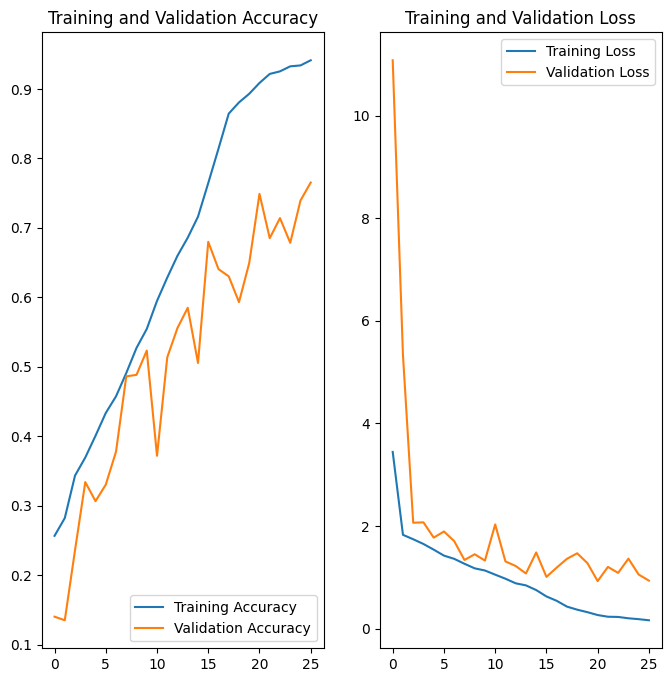

In [138]:
epochs_range_truncated = epochs_range[:len(acc)]

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_truncated, acc, label='Training Accuracy')
plt.plot(epochs_range_truncated, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_truncated, loss, label='Training Loss')
plt.plot(epochs_range_truncated, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
#### From the provided training logs, we can observe the following:

# Training Loss and Accuracy: The training loss steadily decreases over epochs, indicating that the model is learning from the training data. Similarly, the training accuracy gradually increases, showing that the model is getting better at classifying the training samples.

# Validation Loss and Accuracy: The validation loss initially decreases, but then starts to increase after a certain number of epochs. This behavior suggests that the model might be overfitting to the training data, as it performs well on the training data but fails to generalize to unseen data. The validation accuracy also shows a similar trend, peaking at a certain epoch and then potentially decreasing.

# Learning Rate Adjustment: The learning rate scheduler decreases the learning rate exponentially after a certain number of epochs, which is a common technique to fine-tune the model's parameters as training progresses.

# Early Stopping: The early stopping callback is triggered after 26 epochs, indicating that the validation loss did not improve for 5 consecutive epochs. This helps prevent overfitting and saves computational resources by stopping training when further improvement is unlikely.


In [ ]:
###Scope for Improvement:

# Since the validation loss starts to increase after a certain number of epochs, it indicates that the model is overfitting.
# To address this, techniques such as dropout regularization, data augmentation, or adjusting model complexity can be applied.

# Experimenting with different architectures or hyperparameters might also help improve performance.

# Monitoring other metrics such as precision, recall, or F1-score can provide additional insights into the model's performance, especially for imbalanced datasets.

In [ ]:
## To Try these Aspects for Training.

# Rescale images
# Conv2D
# Pooling2D
# 64
# Max Pooling
# FCN 1 Dnse Layer

# Neurons : 8, 16, 32 like. Small
# Increase these step by step.
# Use Simple Model.
# Try 16 Filters.
# Flatenning check.

# Use Test Dataset to measure accuracy.
# need to do 20, 20, 30 Epochs Training.
